# Reading NetCDF's using Pandas DataFrame
## Satellite Image Processing / BioCAST Seed Creation

Includes references to plotting using Matplotlib and related tools.

This program reads in two inputs: 1) APS level 4 satellite image 7 Day composite 2) BioCast generated advection product.  Both are NetCDF's.
The program's goal is to read the inputs, store them, and perform a union of the data with a basic gaussian smoothing to create a "full" image (sometimes a problem due to cloud coverage).
Output the data using NetCDF Best Practices, APS meta-data as an authoritative source, and custom meta-data geared towards future requirements.

NetCDF (Network Common Data Form) is a set of software libraries and self-describing, machine-independent data formats that support the creation, access, and sharing of array-oriented scientific data. The project homepage is hosted by the Unidata program at the University Corporation for Atmospheric Research (UCAR). They are also the chief source of netCDF software, standards development, updates, etc. The format is an open standard. NetCDF Classic and 64-bit Offset Format are an international standard of the Open Geospatial Consortium.

**References:**

+ https://en.wikipedia.org/wiki/NetCDF

+ https://www.unidata.ucar.edu/software/netcdf/

+ https://www.ogc.org/publications/standard/netcdf/

## Project Setup

In [ ]:
# Let's define some variables (information holders) for our project overall
# If using GCP or a similar Cloud Service Provider (CSP), you might be required
# to provide project details.

global PROJECT_ID, BUCKET_NAME, LOCATION
BUCKET_NAME =""
PROJECT_ID  =""
LOCATION    =""

BOLD_START="\033[1m"
BOLD_END="\033[0m"

## Import Base Libraries

In [ ]:
# Import key libraries necessary to support dynamic installation of additional libraries
# Use subprocess to support running operating system commands from the program, using the "bang" (!)
# symbology is supported, however that does not translate to an actual python script, this is a more
# agnostic approach.
###########################################
#- Minimal imports to start
###########################################
try:
    import sys
    import subprocess
    import importlib.util
    import atexit
    import os
except ImportError as e:
    print("There was a problem importing the most basic libraries necessary for this code.")
    print(repr(e))
    raise SystemExit("Stop right there!")

###########################################
#- Final Exit Routine
###########################################
@atexit.register
def goodbye():
    print("GOODBYE")

## Load Minimally Required Libraries

In [ ]:
libraries=["numpy", "pandas", "scipy", "sklearn", "matplotlib", "seaborn", "cartopy",
           "rich", "rich[jupyter]", "unidecode", "icecream",
           "polars[all]", "dask[complete]", "xarray", "netCDF4",
           "tqdm", "watermark",
           "Pillow",]

import importlib.util

for library in libraries:
    if library == "Pillow":
      spec = importlib.util.find_spec("PIL")
    else:
      spec = importlib.util.find_spec(library)
    if spec is None:
      print("Installing library " + library)
      subprocess.run(["pip", "install" , library, "--quiet"])
    else:
      print("Library " + library + " already installed.")

Library numpy already installed.
Library pandas already installed.
Library scipy already installed.
Library sklearn already installed.
Library matplotlib already installed.
Library seaborn already installed.
Library cartopy already installed.
Library rich already installed.
Installing library rich[jupyter]
Library unidecode already installed.
Library icecream already installed.
Installing library polars[all]
Installing library dask[complete]
Library xarray already installed.
Installing library netCDF4
Library tqdm already installed.
Library watermark already installed.
Library Pillow already installed.


## Environment Check

In [ ]:
#- Environment Check
import datetime
import platform

RunningInCOLAB = False
RunningInCOLAB = 'google.colab' in str(get_ipython())
current_time   = datetime.datetime.now()
operating_system=platform.system()

if RunningInCOLAB:
    python_environment=" Google Colab "
    from IPython.core.interactiveshell import InteractiveShell
    InteractiveShell.ast_node_interactivity = "all"
else:
    python_environment=" Python command-line "

print(f"You are running this notebook in {python_environment} at {BOLD_START}{current_time}{BOLD_END} on {BOLD_START}{operating_system}{BOLD_END} in the {BOLD_START}{PROJECT_ID}{BOLD_END} lab.")

You are running this notebook in  Google Colab  at 2025-02-05 20:18:38.533592 on Linux in the  lab.


# Libararies

In [ ]:
############################################
#INCLUDES
############################################
import csv
from datetime import datetime, timedelta
import fnmatch
import statistics
import pickle

#Generally useful / common libraries
import os
import subprocess
import datetime
import sys
import gc
import getopt
import inspect
import math
import warnings
from pathlib import Path

#Data Science
import numpy as np
import pandas as pd
import polars as pl
import dask as da
import xarray as xr
import scipy as sp
import scipy.ndimage

#Pretty Print
from rich import print as rprint
from icecream import ic
from tqdm.notebook import trange, tqdm
from watermark import watermark as the_watermark

#libraries specific to this example
import scipy as sp
from sklearn.linear_model import LinearRegression

#- Graphics
import matplotlib.pyplot as plt
import matplotlib as matplt
import matplotlib
from matplotlib.cbook import get_sample_data
from matplotlib.offsetbox import (AnnotationBbox, DrawingArea, OffsetImage,
                                  TextArea)
from matplotlib.pyplot import imshow
from matplotlib.patches import Circle
from PIL import Image as PIL_Image
import PIL.ImageOps
import seaborn as sns
import cartopy.crs as ccrs

#- Image meta-data for Section 508 compliance
import piexif
from piexif.helper import UserComment

#- Additional libraries for this work
import math
from base64 import b64decode
from IPython.display import Image, Markdown
import pandas, IPython.display as display, io, jinja2, base64
import requests
import unidecode

# for NetCDF output
import netCDF4 as nc
from netCDF4 import Dataset

## Functions

In [ ]:
# Functions are like legos that do one thing, this function outputs library version history of effort.
def lib_diagnostics() -> None:

    import pkg_resources

    package_name_length=20
    package_version_length=10

    data_version_release="-".join([str(VERSION_NAME),str(VERSION_MAJOR), str(VERSION_MINOR), str(VERSION_RELEASE)])
    rprint(f"Software Version Information: {data_version_release}")
    rprint("\n")
    # Show notebook details
    #%watermark?
    #%watermark --github_username christophergwood --email christopher.g.wood@gmail.com --date --time --iso8601 --updated --python --conda --hostname --machine --githash --gitrepo --gitbranch --iversions --gpu
    # Watermark
    rprint(the_watermark(author=f"{AUTHOR_NAME}", github_username=f"GITHUB_USERNAME", email=f"{AUTHOR_EMAIL}",iso8601=True, datename=True, current_time=True, python=True, updated=True, hostname=True, machine=True, gitrepo=True, gitbranch=True, githash=True))


    print(f"{BOLD_START}Packages:{BOLD_END}")
    print("")
    # Get installed packages
    the_packages=["nltk", "numpy", "os", "pandas", "seaborn"]
    installed = {pkg.key: pkg.version for pkg in pkg_resources.working_set}
    for package_idx, package_name in enumerate(installed):
         if package_name in the_packages:
             installed_version = installed[package_name]
             rprint(f"{package_name:<40}#: {str(pkg_resources.parse_version(installed_version)):<20}")

    try:
        rprint(f"{'TensorFlow version':<40}#: {str(tf.__version__):<20}")
        rprint(f"{'     gpu.count:':<40}#: {str(len(tf.config.experimental.list_physical_devices('GPU')))}")
        rprint(f"{'     cpu.count:':<40}#: {str(len(tf.config.experimental.list_physical_devices('CPU')))}")
    except Exception as e:
        pass

    try:
        rprint(f"{'Torch version':<40}#: {str(torch.__version__):<20}")
        rprint(f"{'     GPUs available?':<40}#: {torch.cuda.is_available()}")
        rprint(f"{'     count':<40}#: {torch.cuda.device_count()}")
        rprint(f"{'     current':<40}#: {torch.cuda.current_device()}")
    except Exception as e:
        pass


    try:
      print(f"{'OpenAI Azure Version':<40}#: {str(the_openai_version):<20}")
    except Exception as e:
      pass

    return

In [ ]:
# Routines designed to support adding ALT text to an image generated through Matplotlib.

def capture(figure):
   buffer = io.BytesIO()
   figure.savefig(buffer)
   #return F"data:image/png;base64,{base64.b64encode(buffer.getvalue()).decode()}"
   return F"data:image/jpg;base64,{base64.b64encode(buffer.getvalue()).decode()}"

def make_accessible(figure, template, **kwargs):
   return display.Markdown(F"""![]({capture(figure)} "{template.render(**globals(), **kwargs)}")""")


# requires JPG's or TIFFs
def add_alt_text(image_path, alt_text):
    try:
        if os.path.isfile(image_path):
          img = PIL_Image.open(image_path)
          if "exif" in img.info:
              exif_dict = piexif.load(img.info["exif"])
          else:
              exif_dict={}

          w, h = img.size
          if "0th" not in exif_dict:
            exif_dict["0th"]={}
          exif_dict["0th"][piexif.ImageIFD.XResolution] = (w, 1)
          exif_dict["0th"][piexif.ImageIFD.YResolution] = (h, 1)

          software_version=" ".join(["STEM-001 with Python v", str(sys.version).split(" ")[0]])
          exif_dict["0th"][piexif.ImageIFD.Software]=software_version.encode("utf-8")

          if "Exif" not in exif_dict:
            exif_dict["Exif"]={}
          exif_dict["Exif"][piexif.ExifIFD.UserComment] = UserComment.dump(alt_text, encoding="unicode")

          exif_bytes = piexif.dump(exif_dict)
          img.save(image_path, "jpeg", exif=exif_bytes)
        else:
          rprint(f"Cound not fine {image_path} for ALT text modification, please check your paths.")

    except (FileExistsError, FileNotFoundError, Exception) as e:
        process_exception(e)

# Appears to solve a problem associated with GPU use on Colab, see: https://github.com/explosion/spaCy/issues/11909
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"


In [ ]:
# this function displays the stack trace on errors from a central location making adjustments to the display on an error easier to manage
# functions perform useful solutions for highly repetitive code
def process_exception(inc_exception: Exception) -> None:
  try:
    if DEBUG_STACKTRACE==1:
      traceback.print_exc()
      console.print_exception(show_locals=True)
    else:
      rprint(repr(inc_exception))
  except Exception as e:
    rprint(repr(inc_exception))

In [ ]:
#library configurations examples using Pandas
def setup_libary_configuration() -> None:
    options = {
        'display': {
            'max_columns': None,
            'max_colwidth': 25,
            'expand_frame_repr': False,  # Don't wrap to multiple pages
            'max_rows': 14,
            'max_seq_items': 50,         # Max length of printed sequence
            'precision': 4,
            'show_dimensions': False
        },
        'mode': {
            'chained_assignment': None   # Controls SettingWithCopyWarning
        }
    }

    for category, option in options.items():
        for op, value in option.items():
            pd.set_option(f'{category}.{op}', value)  # Python 3.6+

    #nump equivalent
    np.set_printoptions(precision=4)

## Function Declaration (lots of functions)

In [ ]:
############################################
# WARNING / ERROR Management
############################################
def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()


############################################
# FUNCTIONS
############################################

def prototype(incMonth:str) -> int:

    rprint("Entering {}.{}".format(__name__, inspect.stack()[0][3]))
    rprint("The month you passed in was " + str(incMonth))
    rprint("Exiting {}.{}".format(__name__, inspect.stack()[0][3]))
    return 1


def get_full_version() -> None:

    resultant = str(VERSION_NAME) + "  v" + str(VERSION_MAJOR) + "." + str(VERSION_MINOR) + "." + str(VERSION_RELEASE)
    return resultant

def get_version() -> None:

    resultant = str(VERSION_MAJOR) + "." + str(VERSION_MINOR) + "." + str(VERSION_RELEASE)
    return resultant

def printversion() -> None:

    print(get_full_version())

def printusage() -> None:

    print("")
    printversion()
    print("  -v, --version    prints the version of this software package.")
    print("  -o, --ofile  =  *name of the NetCDF output file (seed for 3DOG ingest).")
    print("  -a, --afile  =  *name of the NetCDF input file (APS generated lvl4 file).")
    print("  -b, --bfile  =  *name of the NetCDF BIOCAST input file (BIOCAST generated, Tau 0).")
    print("  -c, --clobber=   overwrite existing output file.")
    print("")
    print("  * - indicates required argument.")

def show_columns_plain(inc_ary) -> str:
    new_ary = []
    for col in inc_ary:
        new_ary.append(np.char.lower(col))
    new_ary.sort
    myOutputString = " "
    for col in new_ary:
        myOutputString = myOutputString + " " + str(col)
    return myOutputString

def show_columns_true(inc_ary) -> str:
    new_ary = []
    for col in inc_ary:
        new_ary.append(col)
    new_ary.sort
    myOutputString = " "
    for col in new_ary:
        myOutputString = myOutputString + " " + str(col)
    return myOutputString


###
# valid string:
#  We don't want the following:
#   - at the start of the file name (might be construed as a switch)
#  $, &, |, ;, <, >, `, !, *, ", \ (to start with)
###
def validstring(testsubject:str) -> int:

    if testsubject[0] == "-":
        return 0
    elif "$" in testsubject or "&" in testsubject or "|" in testsubject:
        return 0
    elif ";" in testsubject or "`" in testsubject or "!" in testsubject:
        return 0
    elif "*" in testsubject or '"' in testsubject or "\\" in testsubject:
        return 0
    else:
        return 1


def inputusage(flag:str) -> None:

    print("")
    printversion()
    if flag == "input":
        rprint("Input filename must reference a real file and cannot contain:")
        rprint('  $, &, |, ;, <, >, `, !, *, ", \ ')
        rprint("  or start with the character - ")
    elif flag == "biocast":
        rprint("BIOCAST Input filename must reference a real file and cannot contain:")
        rprint('  $, &, |, ;, <, >, `, !, *, ", \ ')
        rprint("  or start with the character - ")
    elif flag == "output":
        rprint("Output filename must not exist and cannot contain:")
        rprint('  $, &, |, ;, <, >, `, !, *, ", \ ')
        rprint("  or start with the character - ")
        rprint(" Set -c or --clobber to overwrite existing file.")
    elif flag == "collision":
        rprint("Input file(s) and/or output file cannot be the same.")
        rprint("...You were joking right?")
    else:
        %rehashxprint("Undefined input error.")


def failure_management(inc_reason: str, inc_exception: Exception) -> None:
    rprint("WARNING - Exception:")
    rprint("...." + str(inc_exception))
    rprint("")
    rprijnt(inc_reason)
    printusage()
    exit(1)


def argument_management(inc_opts, inc_args) -> None:
    global date_to_process, aps_filename, biocast_filename, output_filename, area, clobber

    insufficient_args = "Unable to process the seed as insufficient command line parameters were passed."

    for opt, arg in inc_opts:
        if opt == "-h":
            printusage()
            sys.exit(2)
        elif opt in ("-a", "-A", "-ifile", "--ifile"):
            aps_filename = arg
        elif opt in ("-b", "-B", "-bfile", "--bfile"):
            biocast_filename = arg
        elif opt in ("-o", "-O", "-ofile", "--ofile"):
            output_filename = arg
        elif opt in ("-c", "--clobber"):
            clobber = arg
        elif opt in ("-V", "-v", "-version", "-Version", "--version", "--Version"):
            printversion()
            sys.exit(2)

    if clobber != "true" and clobber != "false":
        msg_warning("Clobber is invalid.")
        msg_warning(clobber)
        printusage()
        sys.exit(1)

    try:
        if ("aps_filename" in locals()) or ("aps_filename" in globals()) and (len(aps_filename) > 0):
            if DEBUG_DATA:
                msg_debug(" APS Input file: " + str(aps_filename))
            if not validstring(aps_filename) or not os.path.isfile(aps_filename):
                msg_warning("APS input filename is invalid or file doesn't exist.")
                inputusage("input")
                exit(1)
        else:
            msg_warning(insufficient_args)
            printusage()
            exit(1)
    except Exception as e:
        failure_management(insufficient_args, str(e))

    try:
        if ("biocast_filename" in locals()) or ("biocast_filename" in globals()) and (len(biocast_filename) > 0):
            if DEBUG_DATA:
                msg_debug(" BIOCAST Input file: " + str(biocast_filename))
            if not validstring(biocast_filename) or not os.path.isfile(biocast_filename):
                msg_warning("BIOCAST Input filename is invalid or file doesn't exist.")
                inputusage("biocast")
                exit(1)
        else:
            msg_warning(insufficient_args)
            printusage()
            exit(1)
    except Exception as e:
        failure_management(insufficient_args, str(e))

    try:
        if ("output_filename" in locals()) or ("output_filename" in globals()) and (len(output_filename) > 0):
            if DEBUG:
                msg_debug("Output file: " + str(output_filename))
            if not validstring(output_filename) or (os.path.exists(output_filename) and clobber != "true"):
                msg_warning("Output filename is invalid or file exists and clobber was not set.")
                inputusage("output")
                exit(1)
        else:
            msg_warning("Unable to process the nowcast without an output file defined.")
            printusage()
            exit(1)
    except Exception as e:
        failure_management(insufficient_args, str(e))

    if output_filename == aps_filename:
        inputusage("collision")
        exit(1)

    if output_filename == biocast_filename:
        inputusage("collision")
        exit(1)

    if aps_filename == biocast_filename:
        inputusage("collision")
        exit(1)

def get_variable_domain(inc_dataset, inc_domain):
    if DEBUG:
        rprint("Entering {}.{}".format(__name__, inspect.stack()[0][3]))

    #based on analysis of variables, the ProductUnits attribute is only present in those
    #variables that have actual geophysical properties, a.k.a. true products
    for var in inc_dataset.get_variables_by_attributes(productUnits=lambda v: v is not None):
        inc_domain.append(var.name)

    if DEBUG:
        rprint("Exiting {}.{}".format(__name__, inspect.stack()[0][3]))

def establish_common_domain(inc_aps_domain, inc_biocast_domain):

    if DEBUG:
        rprint("Entering {}.{}".format(__name__, inspect.stack()[0][3]))

    for var in inc_aps_domain:
        if var in inc_biocast_domain:
            output_variable_domain.append(var)
            rprint("...Found match between both:"+str(var))

    if DEBUG:
        rprint("Exiting {}.{}".format(__name__, inspect.stack()[0][3]))

def show_netcdf_details(inc_dataset, inc_var_domain):
    if DEBUG:
        rprint("Entering {}.{}".format(__name__, inspect.stack()[0][3]))

        try:
            rprint(".......version:" + str(inc_dataset.data_model))
        except Exception as e:
            failure_management("While loading the model climatology a problem occurred.", str(e))

        if (inc_dataset.isopen):
          for attr in inc_var_domain:
            rprint("........processing " + str(attr))
            try:
                variables=inc_dataset.get_variables_by_attributes(name=attr)
                for var in variables:
                   rprint("................name:"+str(var.name))
                   rprint("................dims:"+str(var.ndim))
                   rprint("................type:"+str(var.dtype))
                   rprint("...............shape:"+str(var.shape))
            except Exception as e:
                rprint("Unable to gather details on variable:" + str(attr), str(e))

    if DEBUG:
        rprint("Exiting {}.{}".format(__name__, inspect.stack()[0][3]))

def show_data(inc_df:pd.DataFrame) -> None:

    if isinstance(inc_df,pd.DataFrame):
        try:
            rprint("--------------------------------------------------------------")
            rprint("Columns: " + str(inc_df.columns))
            rprint("\n")
            rprint(f"""{"size":20} : {inc_df.size:15,} """)
            rprint(f"""{"shape":20} : {str(inc_df.shape):>15} """)
            rprint(f"""{"ndim":20} : {inc_df.ndim:15,} """)
            rprint(f"""{"column size":20} : {inc_df.columns.size:15,} """)
            rprint("\n")
            #rprint(str(inc_df.describe()))
            rprint("--------------------------------------------------------------")
        except Exception as e:
            process_exception(e)
    else:
        rprint("In show_data() the incoming dataframe was not a Pandas.DataFrame.")
        rprint("This warning is shown but program execution will continue.")
    return

def create_output(inc_outputfilename, inc_lat_dim, inc_lon_dim, inc_depth_max, inc_depths, inc_fused_data):

    rprint("Entering {}.{}".format(__name__, inspect.stack()[0][3]))

    # dataset = Dataset(inc_outputfilename, 'w', format='NETCDF4_CLASSIC')
    dataset = netcdf.netcdf_file(inc_outputfilename, "w")

    meta_data_input="put something here"
    dataset.title = meta_data_input.encode(ENCODING, errors='ignore').strip()
    meta_data_input=" "
    dataset.subtitle = meta_data_input.encode(ENCODING, errors='ignore')

    depth = dataset.createDimension("depth", inc_depth_max)
    time = dataset.createDimension("time", 1)
    lat = dataset.createDimension("lat", inc_lat_dim)
    lon = dataset.createDimension("lon", inc_lon_dim)
    x = dataset.createDimension("x", inc_lat_dim)
    y = dataset.createDimension("y", inc_lon_dim)
    z = dataset.createDimension("z", inc_depth_max)

    lat_reference = dataset.createVariable("lat", "f8", ("lat",))
    # put units, long_name and other details
    lon_reference = dataset.createVariable("lon", "f8", ("lon",))
    # put units, long_name and other details
    depth_reference = dataset.createVariable("depths", "f8", ("depth",))
    # put units, long_name and other details

    netcdf_variable_output_domain = None
    netcdf_variable_output_domain = variable_output_domain.copy()
    netcdf_variable_output_domain.append("sat_CHL")
    netcdf_variable_output_domain.append("sat_sst")

    for var in netcdf_variable_output_domain:
        if DEBUG:
            rprint("...Processing " + str(var))
        var_reference = dataset.createVariable(var, "f8", ("time", "depth", "lat", "lon"))
        # put units, long_name and other details

    if DEBUG_DATA:
        rprint("  Output file name: " + str(inc_outputfilename))
        rprint("        DIMENSIONS: ")
        for dimname in dataset.dimensions.keys():
            dim = dataset.dimensions[dimname]
            rprint("...." + str(dimname) + ":" + str(dim))
        for varname in dataset.variables.keys():
            var = dataset.variables[varname]
            rprint("...." + str(varname))
            # debug.msg_debug("...." + str(varname) + ":" + str(var.dtype) + " - " + str(var.dimensions) + " - " + str(var.shape))

    rprint("Exiting {}.{}".format(__name__, inspect.stack()[0][3]))

    return dataset

def create_navigation_netcdf_vars(inc_coordinate_hash, output_dataset, inc_DEPTHS):

    rprint("Entering {}.{}".format(__name__, inspect.stack()[0][3]))

    if DEBUG:
        rprint("...latitude")
    lat_netcdf_variable = output_dataset.variables["lat"]
    lat_array = inc_coordinate_hash["lat"]
    lat_netcdf_variable[:] = lat_array

    if DEBUG:
        rprint("...longitude")
    lon_netcdf_variable = output_dataset.variables["lon"]
    lon_array = inc_coordinate_hash["lon"]
    lon_netcdf_variable[:] = lon_array

    if DEBUG:
        rprint("...depths")
    depth_netcdf_variable = output_dataset.variables["depths"]
    depth_array = inc_DEPTHS
    depth_netcdf_variable[:] = depth_array

    rprint("Exiting {}.{}".format(__name__, inspect.stack()[0][3]))


def show_data_distribution(inc_dict1, inc_dict2, inc_variable_domain, inc_name1, inc_name2, inc_outputfile_prefix):

    if DEBUG:
        rprint("Entering {}.{}".format(__name__, inspect.stack()[0][3]))

    for var in inc_variable_domain:
        matplt.use('Agg')
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(1, 1, 1)
        #inc_dataframe[var].hist(bins=10, grid=True)
        sns.distplot(inc_dict1[var], label=inc_name1, kde=False, bins=10)
        sns.distplot(inc_dict2[var], label=inc_name2, kde=False, bins=10)
        plt.legend(prop={'size':12})
        plt.xlabel(str(var), fontsize=15)
        plt.ylabel("Frequency", fontsize=15)
        plt.title(str(var) + " Distribution", fontsize=18)
        output_filename=str(inc_outputfile_prefix) + "_" + str(var) + "_map.png"
        plt.savefig(output_filename)
        plt.close()

    if DEBUG:
        rprint("Exiting {}.{}".format(__name__, inspect.stack()[0][3]))

def show_map_coverage(inc_dataframe_reference, inc_dataframe, inc_name):

    if DEBUG:
        rprint("Entering {}.{}".format(__name__, inspect.stack()[0][3]))

    coordinate_offset=0.5
    new_df = inc_dataframe
    TARGET_DATAFRAME = inc_dataframe_reference

    central_longitude       = np.median(TARGET_DATAFRAME[geospatial_lon_nm])
    central_latitude        = np.median(TARGET_DATAFRAME[geospatial_lat_nm])
    west                    = np.min(TARGET_DATAFRAME[geospatial_lon_nm]) - coordinate_offset
    east                    = np.max(TARGET_DATAFRAME[geospatial_lon_nm]) + coordinate_offset
    north                   = np.max(TARGET_DATAFRAME[geospatial_lat_nm]) + coordinate_offset
    south                   = np.min(TARGET_DATAFRAME[geospatial_lat_nm]) - coordinate_offset

    slice_central_longitude = new_df[geospatial_lon_nm].median()
    slice_central_latitude  = new_df[geospatial_lat_nm].median()
    slice_west              = new_df[geospatial_lon_nm].min() - coordinate_offset
    slice_east              = new_df[geospatial_lon_nm].max() + coordinate_offset
    slice_north             = new_df[geospatial_lat_nm].max() + coordinate_offset
    slice_south             = new_df[geospatial_lat_nm].min() - coordinate_offset

    if (DEBUG_DATA):
        rprint("    {}      {}".format("Coord Hash", "Depth Slice"))
        rprint("{}  {}      {}".format("Cent Long", central_longitude, slice_central_longitude))
        rprint("{}  {}      {}".format("Cent Lat", central_latitude, slice_central_latitude))
        rprint("{}  {}      {}".format("West", west, slice_west))
        rprint("{}  {}      {}".format("East", east, slice_east))
        rprint("{}  {}      {}".format("North", north, slice_north))
        rprint("{}  {}      {}".format("South", south, slice_south))

    matplt.use('Agg')
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Miller())
    ax.set_extent([west, east, south, north])
    ax.coastlines()
    ax.stock_img()
    ax.gridlines()
    ax.add_wms(wms="http://vmap0.tiles.osgeo.org/wms/vmap0", layers=["basic"])

    DATA_COLOR = "red"
    DATA_SIZE = 0.10

    ax.scatter(new_df[geospatial_lon_nm], new_df[geospatial_lat_nm], c=DATA_COLOR, s=DATA_SIZE)

    output_filename=str(inc_name) + f"_map{IMG_EXT}"
    rprint("Graphics output filename:"+str(output_filename))
    plt.savefig(output_filename)
    plt.close()

    if DEBUG:
        rprint("Exiting {}.{}".format(__name__, inspect.stack()[0][3]))

def take_out_trash():
    if (gc.isenabled()):
        try:
            gc.collect()
        except Exception as e:
            rprint("WARNING - Unable to garbage collect.")
    else:
        try:
            gc.enable()
            gc.collect()
        except Exception as e:
            rprint("WARNING - Tried to turn on automatic garbage collection and collect but failed.")

def gather_aps_metadata(inc_auth_netcdf):

    if DEBUG:
        rprint("Entering {}.{}".format(__name__, inspect.stack()[0][3]))

    #set global attribution, copy the originating APS NetCDF and replicate
    try:
        global_name_list=inc_auth_netcdf.ncattrs()
    except Exception as e:
            rprint("Unable to invoke .ncattrs on the APS netcdf file in {}.{}.".format(__name__, inspect.stack()[0][3]))

    rprint("...gathering and posting APS global attribution")
    value=""
    for name in global_name_list:
        try:
            value=inc_auth_netcdf.getncattr(name)
            rprint("..........{} -> {}".format(name, value))
        except Exception as e:
            rprint("Unable to invoke .getncattr({}) on the APS netcdf file in {}.{}.".format(name,__name__, inspect.stack()[0][3]))
        netcdf_metadata[name]=value

    rprint("...finished gathering and posting APS global attribution")

    if DEBUG:
        rprint("Exiting {}.{}".format(__name__, inspect.stack()[0][3]))

def load_project_meta_data():
    if DEBUG:
        rprint("Entering {}.{}".format(__name__, inspect.stack()[0][3]))

    #assumes exposure of environmental variables from OFM Consolidated System (regional meta-data environment file)
    #design is to fail gracefully with logging (warn) in case environment file is not loaded
    #example:
    #    export NETCDF_METADATA_nm_title="title";                                      #Name of file (perhaps includes content)
    env_var_names=["title", "create_date", "rp_org", "rp_name", "rp_phone", "rp_email", "conventions", "nb_latitude", "sb_latitude", "eb_longitude", "wb_longitude",
                "geo_desc", "refsys_code", "refsys_title", "ism_diststatement", "ism_class", "ism_ownerproducer"]

    for var_name in env_var_names:
        if (DEBUG_DATA):
            rprint("......{}".format(var_name))
        try:
            metadata_name=os.getenv("NETCDF_METADATA_nm_"+str(var_name))
            metadata_value=os.getenv("NETCDF_METADATA_val_"+str(var_name))
            netcdf_metadata[metadata_name]=metadata_value.encode(ENCODING,errors='ignore').strip()
        except Exception as e:
            rprint("{} environmental variable not found in {}.{}.".format(var_name, __name__, inspect.stack()[0][3]))

    if DEBUG:
        rprint("Exiting {}.{}".format(__name__, inspect.stack()[0][3]))

def post_all_metadata (out_netcdf):

    if DEBUG:
        rprint("Entering {}.{}".format(__name__, inspect.stack()[0][3]))

    rprint("...starting iteration through netcdf dictionary")

    #iterate through the data and push it to the netcdf now
    for key in netcdf_metadata:
        try:
            out_netcdf.setncattr(key, netcdf_metadata[key])
        except Exception as e:
            rprint("Unable to invoke .setncattr({}) on the output netcdf file in {}.{}.".format(key,__name__, inspect.stack()[0][3]))

    rprint("...finished iteration through netcdf dictionary")

    if DEBUG:
        rprint("Exiting {}.{}".format(__name__, inspect.stack()[0][3]))

def post_metadata(auth_dataset, out_dataset):
    if DEBUG:
        rprint("Entering {}.{}".format(__name__, inspect.stack()[0][3]))

    #load the project level NetCDF meta-data
    load_project_meta_data()

    try:
        # MINIMAL ATTRIBUTES (NetCDF Best Practices and CF), ensures nothing is missing from project netcdf meta-data
        metadata_name="create_date"
        metadata_input=str(datetime.datetime.now().strftime("%m/%d/%Y, %H:%M:%S"))
        final_metadata_input = metadata_input.encode(ENCODING,errors='ignore').strip()
        netcdf_metadata[metadata_name]=final_metadata_input
    except Exception as e:
            rprint("{} unable to set metadata attribute {} in {}.{} to the dictionary.".format(metadata_name, var_name, __name__, inspect.stack()[0][3]))

    #history
    try:
        metadata_name="history"
        metadata_input=str("Created with " + str(get_version()))
        final_metadata_input = metadata_input.encode(ENCODING,errors='ignore').strip()
        netcdf_metadata[metadata_name]=final_metadata_input
    except Exception as e:
            rprint("{} unable to set metadata attribute {} in {}.{} to the dictionary.".format(metadata_name, var_name, __name__, inspect.stack()[0][3]))

    #title
    try:
        metadata_name="title"
        if (metadata_name in netcdf_metadata.keys()):
            if (len(netcdf_metadata[metadata_name])> 0):
                metadata_input = netcdf_metadata[metadata_name]
        else:
            metadata_input =  VERSION_TITLE
        netcdf_metadata[metadata_name]=metadata_input
    except Exception as e:
            rprint("{} unable to set metadata attribute {} in {}.{} to the dictionary.".format(metadata_name, var_name, __name__, inspect.stack()[0][3]))

    #description
    try:
        metadata_name="description"
        if (metadata_name in netcdf_metadata.keys()):
            if (len(netcdf_metadata[metadata_name])> 0):
                metadata_input = netcdf_metadata[metadata_name]
        else:
            metadata_input =  METADATA_DESCRIPTION
        netcdf_metadata[metadata_name]=metadata_input
    except Exception as e:
            rprint("{} unable to set metadata attribute {} in {}.{} to the dictionary.".format(metadata_name, var_name, __name__, inspect.stack()[0][3]))


    #distribution statement
    try:
        metadata_name="distribution_statement"
        if (metadata_name in netcdf_metadata.keys()):
            if (len(netcdf_metadata[metadata_name])> 0):
                metadata_input = netcdf_metadata[metadata_name]
        else:
            metadata_input =  METADATA_DISTRIBUTION
        netcdf_metadata[metadata_name]=metadata_input
    except Exception as e:
            rprint("{} unable to set metadata attribute {} in {}.{} to the dictionary.".format(metadata_name, var_name, __name__, inspect.stack()[0][3]))

    #references
    try:
        metadata_name="references"
        if (metadata_name in netcdf_metadata.keys()):
            if (len(netcdf_metadata[metadata_name])> 0):
                metadata_input = netcdf_metadata[metadata_name]
        else:
            metadata_input =  METADATA_REFERENCES
        netcdf_metadata[metadata_name]=metadata_input
    except Exception as e:
            rprint("{} unable to set metadata attribute {} in {}.{} to the dictionary.".format(metadata_name, var_name, __name__, inspect.stack()[0][3]))

    #institution
    try:
        metadata_name="institution"
        if (metadata_name in netcdf_metadata.keys()):
            if (len(netcdf_metadata[metadata_name])> 0):
                metadata_input = netcdf_metadata[metadata_name]
        else:
            metadata_input =  METADATA_INSTITUTION
        netcdf_metadata[metadata_name]=metadata_input
    except Exception as e:
            rprint("{} unable to set metadata attribute {} in {}.{} to the dictionary.".format(metadata_name, var_name, __name__, inspect.stack()[0][3]))

    #source
    try:
        metadata_name="source"
        if (metadata_name in netcdf_metadata.keys()):
            if (len(netcdf_metadata[metadata_name])> 0):
                metadata_input = netcdf_metadata[metadata_name]
        else:
            metadata_input =  METADATA_SOURCE
        netcdf_metadata[metadata_name]=metadata_input
    except Exception as e:
            rprint("{} unable to set metadata attribute {} in {}.{} to the dictionary.".format(metadata_name, var_name, __name__, inspect.stack()[0][3]))

    #comment
    try:
        metadata_name="comment"
        if (metadata_name in netcdf_metadata.keys()):
            if (len(netcdf_metadata[metadata_name])> 0):
                metadata_input = netcdf_metadata[metadata_name]
        else:
            metadata_input =  METADATA_COMMENT
        netcdf_metadata[metadata_name]=metadata_input
    except Exception as e:
            rprint("{} unable to set metadata attribute {} in {}.{} to the dictionary.".format(metadata_name, var_name, __name__, inspect.stack()[0][3]))

    #take the original APS data and push (as authoritative) into the NetCDF output file
    rprint("...gathering aps meta-data, as authoritative.")
    gather_aps_metadata(auth_dataset)

    ####################################################################################################################################
    #custom changes, metadata APS has that should be in the default/required Global attribution
    #source = "OFM_seed_generator (OFMSG) 0.0.1" ;
    try:
        source=[]
        source.append(netcdf_metadata['inputParameters'] + " from the following files: " + netcdf_metadata['inputFiles'])
        source.append(netcdf_metadata[os.getenv("NETCDF_METADATA_nm_rp_org")])     #long term standards
        source.append(netcdf_metadata['file'])                                     #APS value
        source.append(netcdf_metadata["geospatial_lat_max"])                       #APS value
        source.append(netcdf_metadata["geospatial_lat_min"])                       #APS value
        source.append(netcdf_metadata["geospatial_lon_max"])                       #APS value
        source.append(netcdf_metadata["geospatial_lon_min"])                       #APS value
        source.append(", ".join(output_variable_domain))
        source.append(netcdf_metadata['inputParameters'] + " from the following files: " + netcdf_metadata['inputFiles'])
        source.append(netcdf_metadata['ism_NoticeText'])                           #Long term standard, alreadyloaded

        target=['history', 'institution', 'source']                                #CF / NetCDF Best Practices
        target.append(os.getenv("NETCDF_METADATA_nm_nb_latitude"))                 #long term standards
        target.append(os.getenv("NETCDF_METADATA_nm_sb_latitude"))                 #long term standards
        target.append(os.getenv("NETCDF_METADATA_nm_eb_longitude"))                #long term standards
        target.append(os.getenv("NETCDF_METADATA_nm_wb_longitude"))                #long term standards
        target.append('prodList')                                                  #corrected because this is the intersection of two files
        target.append('lineage')                                                   #long term standards
        target.append('distribution_statement')                                    #standard classification concern


        for idx in range(0, len(target)):
            try:
                metadata_name=target[idx]
                netcdf_metadata[metadata_name]=source[idx]  #default within consolidated source metadata env vars
            except Exception as e:
                rprint("WARNING: Unable to set metadata attribute {} from {} in {}.{} to the dictionary.".format(metadata_name, target_key, __name__, inspect.stack()[0][3]))
    except Exception as e:
            rprint("Failed to set custom attribution, some meta-data is likely changed or missing from a source document in {}.{}.".format( __name__, inspect.stack()[0][3]))

    ####################################################################################################################################

    #final write
    rprint("...write the actual output to the file.")
    post_all_metadata(out_dataset)

    if DEBUG:
        rprint("Exiting {}.{}".format(__name__, inspect.stack()[0][3]))

## Variable declaration

In [ ]:
############################################
# GLOBAL VARIABLES
############################################
DEBUG = 1
DEBUG_DATA = 1
# used to fully display the error stack, set to 1 if you want to see a ridiculous amount of debugging information
DEBUG_STACKTRACE=0

VERSION_NAME    = "NETCDF-READER"
VERSION_ACRONYM = "NCR"
VERSION_MAJOR   = 0
VERSION_MINOR   = 0
VERSION_RELEASE = 1
VERSION_TITLE   = VERSION_NAME + " (" + VERSION_NAME + ") " + str(VERSION_MAJOR) + "." + str(VERSION_MINOR) + "." + str(VERSION_RELEASE) + " generated SEED."


# API Parameters for things like WordCloud, variables help hold information for later use
# The "constants" represent variables that we don't anticipate changing over the course of the program.
IMG_BACKGROUND="black"     #options are black, white, another color or None
IMG_FONT_SIZE_MIN=10
IMG_WIDTH=1024
IMG_HEIGHT=768
IMG_INTERP="bilinear"
IMG_ALPHA=0.8
IMG_ASPECT="equal"
FIGURE_WIDTH=11
FIGURE_HEIGHT=8.5
WORD_FREQ=10

# specify how image formats will be saved
IMG_EXT=".jpg"

# location of our working files
WORKING_FOLDER="/content/folderOnColab"
SRC_DIR=WORKING_FOLDER

# Notebook Author details
AUTHOR_NAME="Christopher G Wood"
GITHUB_USERNAME="christophergarthwood"
AUTHOR_EMAIL="christopher.g.wood@gmail.com"

# Encoding
ENCODING  ="utf-8"
os.environ['PYTHONIOENCODING']=ENCODING

############################################
# CONSTANTS
############################################
MINIMAL_VALUE=0.0001                  #Normally a _FillValue would be used but different NetCDF implementations
                                      #are treating some values differently or don't even have the concept.
METADATA_DESCRIPTION = "Product composite using a daily satellite image coupled with a BioCast background field; used to SEED the optical field."
METADATA_DISTRIBUTION= "Distribution Statement A: Approved for public release; distribution unlimited."
METADATA_REFERENCES  = "None"
METADATA_INSTITUTION = "Naval Research Lab (NRL)"
METADATA_SOURCE      = VERSION_NAME + " (" + VERSION_ACRONYM + ") " + str(VERSION_MAJOR) + "." + str(VERSION_MINOR) + "." + str(VERSION_RELEASE)
METADATA_COMMENT     = "None"


############################################
# APPLICATION VARIABLES
############################################
FILL_VALUE=-32767.0

aps_filename  = ""                     #APS NetCDF (daily file) filename
aps_df        = pd.DataFrame()         #Dataframe that holds APS geospatial data
aps_products  = {}                     #Dictionary of "products" each encapsulated in a dataframe

biocast_filename= ""                   #BIOCAST NetCDF Tau 0 (initial forecast), background (to fill in APS)
biocast_panda   = pd.DataFrame()       #Dataframe that holds BIOCAST geospatial data
biocast_products={}                    #Dictionary of "Products" each encapsulated in a dataframe

output_filename = ""
output_panda    = pd.DataFrame()
output_products={}

todayIs = datetime.datetime.now()
date_to_process = todayIs
clobber = "false"
aps_variable_domain=[]
biocast_variable_domain=[]
output_variable_domain=[]

netcdf_metadata={}

geospatial_lat_nm='lat'
geospatial_lon_nm='lon'
aps_lat_nm="y"
aps_lon_nm="x"
#note x,y values are shown below as they are part of the APS meta-data
#based on the NetCDF Best Practice subject x,y vars should not exist.
#keeping for continuity between BIOCAST code already written to read APS input.
geospatial_vars = [geospatial_lat_nm, geospatial_lon_nm, aps_lat_nm, aps_lon_nm]

## Define some Environment Variables

In [ ]:
#temporary environment variable declaration
os.environ["NETCDF_METADATA_nm_title"]="title";
os.environ["NETCDF_METADATA_nm_create_date"]="createDate";
os.environ["NETCDF_METADATA_nm_rp_org"]="rp_organization";
os.environ["NETCDF_METADATA_nm_rp_name"]="rp_name";
os.environ["NETCDF_METADATA_nm_rp_phone"]="rp_phone";
os.environ["NETCDF_METADATA_nm_rp_email"]="rp_email";
os.environ["NETCDF_METADATA_nm_conventions"]="conventions";
os.environ["NETCDF_METADATA_val_title"]="";
os.environ["NETCDF_METADATA_val_create_date"]="";
os.environ["NETCDF_METADATA_val_rp_org"]="Naval Research Lab (NRL)";
os.environ["NETCDF_METADATA_val_rp_name"]="Christopher G Wood";
os.environ["NETCDF_METADATA_val_rp_phone"]="228-688-4755";
os.environ["NETCDF_METADATA_val_rp_email"]="christopher.wood@nrlssc.navy.mil";
os.environ["NETCDF_METADATA_val_conventions"]="National System for Geospatial Integlligence (NSG) Meatadata Foundation (NMF), Version 3.0, 2016-08-31 (NGA.STD.0012-3.0)"
os.environ["NETCDF_METADATA_nm_nb_latitude"]="geoBoundingBox_northBoundLatitude";
os.environ["NETCDF_METADATA_nm_sb_latitude"]="geoBoundingBox_southBoundLatitude";
os.environ["NETCDF_METADATA_nm_eb_longitude"]="geoBoundingBox_eastBoundLongitude";
os.environ["NETCDF_METADATA_nm_wb_longitude"]="geoBoundingBox_westBoundLongitude";
os.environ["NETCDF_METADATA_nm_geo_desc"]="geoDescription";
os.environ["NETCDF_METADATA_nm_refsys_code"]="referenceSystem_code";
os.environ["NETCDF_METADATA_nm_refsys_title"]="referenceSystem_title";
os.environ["NETCDF_METADATA_val_nb_latitude"]="";
os.environ["NETCDF_METADATA_val_sb_latitude"]="";
os.environ["NETCDF_METADATA_val_eb_longitude"]="";
os.environ["NETCDF_METADATA_val_wb_longitude"]="";
os.environ["NETCDF_METADATA_val_geo_desc"]="Pseudo-Mercator";
os.environ["NETCDF_METADATA_val_refsys_code"]="Geodetic Geographic 3D";
os.environ["NETCDF_METADATA_val_refsys_title"]="EPSG:4326 (WGS 84)";
os.environ["NETCDF_METADATA_nm_start_date"]="start_date";
os.environ["NETCDF_METADATA_nm_start_time"]="start_time";
os.environ["NETCDF_METADATA_nm_stop_date"]="stop_date";
os.environ["NETCDF_METADATA_nm_stop_time"]="stop_time";
os.environ["NETCDF_METADATA_val_start_date"]=""
os.environ["NETCDF_METADATA_val_start_time"]="";
os.environ["NETCDF_METADATA_val_stop_date"]="";
os.environ["NETCDF_METADATA_val_stop_time"]="";
os.environ["NETCDF_METADATA_nm_lineage"]="lineage";
os.environ["NETCDF_METADATA_val_lineage"]="";
os.environ["NETCDF_METADATA_nm_ism_diststatement"]="ism_NoticeText";
os.environ["NETCDF_METADATA_nm_ism_class"]="ism_classification";
os.environ["NETCDF_METADATA_nm_ism_ownerproducer"]="ism_ownerProducer";
os.environ["NETCDF_METADATA_val_ism_diststatement"]="Distribution Statement A: Approved for public release; distribution unlimited.";
os.environ["NETCDF_METADATA_val_ism_class"]="Unclassified";
os.environ["NETCDF_METADATA_val_ism_ownerproducer"]="USA";

## Library Invocation

In [ ]:
rprint("Library Diagnostics")
setup_libary_configuration()
lib_diagnostics()

Library Diagnostics

Software Version Information: NETCDF-READER-0-0-1

Author: Christopher G Wood

Github username: GITHUB_USERNAME

Email: christopher.g.wood@gmail.com

Last updated: 2025-02-05T20:36:56.407068+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 5.15.167+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

Hostname: 757a20244e36

Git hash: 

Git repo: 

Git branch:

Packages:



nltk                                    #: 3.9.1

numpy                                   #: 1.26.4

pandas                                  #: 2.2.2

seaborn                                 #: 0.13.2

## Data Read

In [ ]:
target_folder=WORKING_FOLDER

target_files=["1uYMFrdeVD7_qvG2wRbyu6ir9C6b4wAZC", "19q17MtNuUgNO64s_VdWkk2Ks2U8M_xvS", "1gxy8iCNjDk9Yyt4NJK4NWfDhaubKgHh4"]
target_filenames=["MissBight_2020010900.nc", "npp.201997.MMDD.2019103.0413.D.L4-7DLP.viirsn.MissBight.v08.750m.nc", "example_seed.nc"]

rprint(f"Creating a folder ({target_folder}) to store project data.")

try:
  if os.path.isfile(target_folder):
    raise OSError("Cannot create your folder a file of the same name already exists there, work with your instructor or remove it yourself.")
  elif os.path.isdir(target_folder):
    print(f"The folder named ({target_folder}) {BOLD_START}already exists{BOLD_END}, we won't try to create a new folder.")
  else:
    subprocess.run(["mkdir", "-p" , target_folder], check=True)
except (subprocess.CalledProcessError, Exception) as e:
  process_exception(e)

for idx, the_name in enumerate(target_files):
  try:
    rprint(f"...downloading {target_filenames[idx]}.")
    subprocess.run(["gdown", f"{the_name}", "--no-check-certificate",  "--continue", "-O", f"{target_folder}{os.sep}{target_filenames[idx]}"], check=True)
  except (subprocess.CalledProcessError, Exception) as e:
    process_exception(e)
    raise SystemError

rprint("Files downloaded:")
cmd=["ls ", "-alR", f"{target_folder}{os.sep}*",]
completed_process=subprocess.run(cmd, check=True, shell=True, capture_output=True, text=True)
if (completed_process.returncode==0):
  rprint(completed_process.stdout)
else:
  rprint(f"Command failed with error code of: {completed_process.returncode}")

Creating a folder (/content/folderOnColab) to store project data.

The folder named (/content/folderOnColab) already exists, we won't try to create a new folder.


...downloading MissBight_2020010900.nc.

CompletedProcess(args=['gdown', '1uYMFrdeVD7_qvG2wRbyu6ir9C6b4wAZC', '--no-check-certificate', '--continue', '-O', '/content/folderOnColab/MissBight_2020010900.nc'], returncode=0)

...downloading npp.201997.MMDD.2019103.0413.D.L4-7DLP.viirsn.MissBight.v08.750m.nc.

CompletedProcess(args=['gdown', '19q17MtNuUgNO64s_VdWkk2Ks2U8M_xvS', '--no-check-certificate', '--continue', '-O', '/content/folderOnColab/npp.201997.MMDD.2019103.0413.D.L4-7DLP.viirsn.MissBight.v08.750m.nc'], returncode=0)

...downloading example_seed.nc.

CompletedProcess(args=['gdown', '1gxy8iCNjDk9Yyt4NJK4NWfDhaubKgHh4', '--no-check-certificate', '--continue', '-O', '/content/folderOnColab/example_seed.nc'], returncode=0)

Files downloaded:

All_flo-thru.dat
folderOnColab

In [ ]:
############################################
# MAIN
############################################
#try:
#     opts, args = getopt.getopt(
#          argv, "VvHhB:b:A:a::O:o:c:", ["afile=", "bfile=", "ofile=", "clobber="]
#      )
#except getopt.GetoptError:
#      printusage()
#      sys.exit(2)
#argument_management(opts, args)

warnings.filterwarnings("ignore")

#Setup filenames
aps_filename    =target_folder+os.sep+"npp.201997.MMDD.2019103.0413.D.L4-7DLP.viirsn.MissBight.v08.750m.nc"
biocast_filename=target_folder+os.sep+"MissBight_2020010900.nc"
output_filename =target_folder+os.sep+"example_seed.nc"


rprint("Started " + str(VERSION_NAME) + ".")
rprint(f"""{"APS Filename":15} : {aps_filename:40}.""")
rprint(f"""{"BioCast Filename":15}: {biocast_filename:40}.""")


Started NETCDF-READER.

APS Filename    : /content/folderOnColab/npp.201997.MMDD.2019103.0413.D.L4-7DLP.viirsn.MissBight.v08.750m.nc.

BioCast Filename: /content/folderOnColab/MissBight_2020010900.nc.

## Read Input NetCDF Files

In [ ]:
#write defensive code that fails fast, use try/exceptions where it makes sense.
try:
    aps_netcdf = Dataset(aps_filename, "r", format="NETCDF4")
    #note that APS output is not packed
    aps_netcdf.set_auto_scale(True)
except Exception as e:
    process_exception(e)

if (DEBUG_DATA):
    rprint("NetCDF (aps) opened.")
    get_variable_domain(aps_netcdf, aps_variable_domain)
    show_netcdf_details(aps_netcdf, aps_variable_domain)

try:
    biocast_netcdf = Dataset(biocast_filename, "r", format="NETCDF4")
    #note that BIOCAST output is not packed
    biocast_netcdf.set_auto_scale(True)
except Exception as e:
    process_exception(e)

if (DEBUG_DATA):
    rprint("NetCDF (biocast) opened.")
    get_variable_domain(biocast_netcdf, biocast_variable_domain)
    show_netcdf_details(biocast_netcdf, biocast_variable_domain)


NetCDF (aps) opened.

Entering __main__.get_variable_domain

Exiting __main__.get_variable_domain

Entering __main__.show_netcdf_details

.......version:NETCDF4

........processing salinity

................name:salinity

................dims:2

................type:int16

...............shape:(400, 800)

........processing chlor_a

................name:chlor_a

................dims:2

................type:float32

...............shape:(400, 800)

........processing vis_lmi_c

................name:vis_lmi_c

................dims:2

................type:int16

...............shape:(400, 800)

........processing vis_lmi_a

................name:vis_lmi_a

................dims:2

................type:int16

...............shape:(400, 800)

........processing vis_lmi_bb

................name:vis_lmi_bb

................dims:2

................type:int16

...............shape:(400, 800)

........processing vis_lmi_Kd

................name:vis_lmi_Kd

................dims:2

................type:int16

...............shape:(400, 800)

........processing Kd_486_lee

................name:Kd_486_lee

................dims:2

................type:int16

...............shape:(400, 800)

........processing bb_551_qaa

................name:bb_551_qaa

................dims:2

................type:int16

...............shape:(400, 800)

........processing c_551_qaa

................name:c_551_qaa

................dims:2

................type:float32

...............shape:(400, 800)

........processing Kd_490

................name:Kd_490

................dims:2

................type:int16

...............shape:(400, 800)

........processing Zeu_lee

................name:Zeu_lee

................dims:2

................type:int16

...............shape:(400, 800)

........processing cloud_albedo

................name:cloud_albedo

................dims:2

................type:float32

...............shape:(400, 800)

........processing latitude

................name:latitude

................dims:2

................type:float32

...............shape:(400, 800)

........processing longitude

................name:longitude

................dims:2

................type:float32

...............shape:(400, 800)

Exiting __main__.show_netcdf_details

NetCDF (biocast) opened.

Entering __main__.get_variable_domain

Exiting __main__.get_variable_domain

Entering __main__.show_netcdf_details

.......version:NETCDF3_CLASSIC

........processing chlor_a

................name:chlor_a

................dims:4

................type:float32

...............shape:(1, 29, 400, 800)

Exiting __main__.show_netcdf_details

## Build Panda.DataFrame() structures for data

In [ ]:
#BUILD DATAFRAMES (Create common geospatial structure)

try:
    #iterate through the set of NetCDF variables in each input file
    #find the union of both variable sets, that's the most you can merge
    establish_common_domain(aps_variable_domain, biocast_variable_domain)
    output_variable_domain=['chlor_a']
except Exception as e:
    failure_management("Unable to match variables in APS to BIOCAST NetCDF.", str(e))

rprint("APS Coordinates to pd.DataFrame().")
#flatten the output from APS, which is a grid of points, and get the unique list of lats, that's Y
#technically APS outputs an x,y set of values that a 1D but that name is not consistent.
lat = np.array(aps_netcdf.variables[geospatial_lat_nm][:][:]).flatten()
lat = np.unique(lat)
lon = np.array(aps_netcdf.variables[geospatial_lon_nm][:][:]).flatten()
lon = np.unique(lon)

latSeries=pd.Series(lat)
lonSeries=pd.Series(lon)

#define a Panda.DataFrame()
frame={geospatial_lat_nm: latSeries, geospatial_lon_nm: lonSeries}

#instantiate a dataframe
aps_panda=pd.DataFrame(frame)

#ensure the data is cast as expected
aps_panda[geospatial_lat_nm].astype('float64')
aps_panda[geospatial_lon_nm].astype('float64')

#clean-up to ensure memory is kept minimal...not sure if this really matters.
del lat, lon, latSeries, lonSeries, frame

#biocast is a lat and lon of 1d, we're going to keep it that way
rprint("BIOCAST Coordinates to pd.DataFrame().")

#could access via lat=biocast_netcdf[geosptaial_lat_nm]
#            then print(lat[0]) for a value.
lat   =np.array(biocast_netcdf.variables[geospatial_lat_nm][:][:]).flatten()
lon   =np.array(biocast_netcdf.variables[geospatial_lon_nm][:][:]).flatten()
latSeries=pd.Series(lat)
lonSeries=pd.Series(lon)
frame={geospatial_lat_nm: latSeries, geospatial_lon_nm: lonSeries}
biocast_panda=pd.DataFrame(frame)
biocast_panda[geospatial_lat_nm].astype('float64')
biocast_panda[geospatial_lon_nm].astype('float64')

del lat, lon, latSeries, lonSeries, frame

#keep an independent geographic setup for output (to keep things consistent), but use BIOCAST as the basis for that system
rprint("Copy BIOCAST Coordinates to Output pd.DataFrame().")
output_panda = biocast_panda.copy()

take_out_trash()

Entering __main__.establish_common_domain

...Found match between both:chlor_a

Exiting __main__.establish_common_domain

APS Coordinates to pd.DataFrame().

,lat
0,28.3832
1,28.3899
2,28.3965
3,28.4031
4,28.4098
...,...
795,NaN
796,NaN
797,NaN
798,NaN


,lon
0,-90.5000
1,-90.4925
2,-90.4850
3,-90.4775
4,-90.4700
...,...
795,-84.5276
796,-84.5201
797,-84.5126
798,-84.5050


BIOCAST Coordinates to pd.DataFrame().

,lat
0,31.0000
1,30.9935
2,30.9871
3,30.9806
4,30.9741
...,...
795,NaN
796,NaN
797,NaN
798,NaN


,lon
0,-90.5000
1,-90.4925
2,-90.4850
3,-90.4775
4,-90.4699
...,...
795,-84.5278
796,-84.5203
797,-84.5128
798,-84.5053


Copy BIOCAST Coordinates to Output pd.DataFrame().

## Gather NetCDF Variable data and store for future use

In [ ]:
#dictionary to hold 1 to N data frames of products.
for var in output_variable_domain:
    rprint("Processing {}".format(var))
    varAry=np.array(aps_netcdf.variables[var][:][:])
    df = pd.DataFrame(data=varAry)
    aps_products[var]=df

    #handle cloud coverage by setting non-valid data to 0.0
    #note that _FillValue should be used by it has an "improper name"
    #and the value is set packed versus unpacked.
    aps_mangled=aps_products[var].values
    aps_fixed = np.where(aps_mangled > MINIMAL_VALUE, aps_mangled, 0.0)
    df = pd.DataFrame(data=aps_fixed)
    aps_products[var]=df

    varAry=np.array(biocast_netcdf.variables[var][0][0][:][:])
    df = pd.DataFrame(data=varAry)
    biocast_products[var] = df

#clean up varaible use
del varAry, df

#force garbage collection, read the routine, this is not native.
take_out_trash()

Processing chlor_a

## Get a Quick view of the APS Product (Original)

Note that `var` is the last variable processed in an array of potential products unioned between both inputs.

In [ ]:
matplt.use('Agg')

from matplotlib import pyplot as plt
#plt.figure(figsize = (40,10))
fig, axes = plt.subplots(figsize=(FIGURE_WIDTH,FIGURE_HEIGHT));

# Save the plot to a file that can be pulled up at a later date.
target_filename=target_folder+os.sep+f"007_netcdf_chlora{IMG_EXT}";

# Create ALT text describing the image.
caption_text=f"Plot of Chlorophyll-A for the Gulf of Mexico's MS Bight region, saving results to {target_filename}.";

plt.imshow(aps_products[var],cmap='inferno')
plt.savefig(target_filename);
add_alt_text(target_folder+os.sep+f"005_insitu_merger_all{IMG_EXT}", caption_text);
rprint("Next display is a " + caption_text);

Next display is a Plot of Chlorophyll-A for the Gulf of Mexico's MS Bight region, saving results to 
/content/folderOnColab/007_netcdf_chlora.jpg.

![](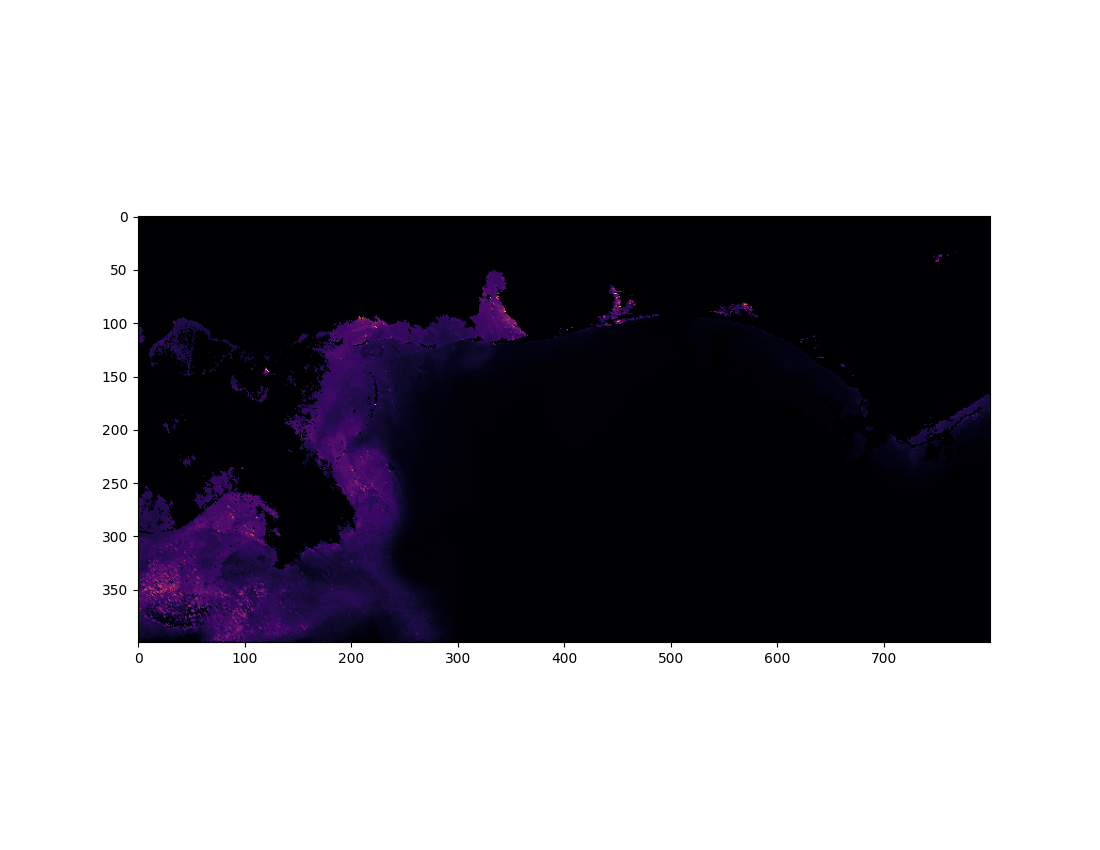 "Plot of Chlorophyll-A for the Gulf of Mexico's MS Bight region, saving results to /content/folderOnColab/007_netcdf_chlora.jpg.")

Plot of Chlorophyll-A for the Gulf of Mexico's MS Bight region, saving results to 
/content/folderOnColab/007_netcdf_chlora.jpg.

In [ ]:
# Display Section 508 compliant image on the scrren with ALT text
try:
  make_accessible(plt, jinja2.Template(caption_text), len=len)
  rprint("\n")
  rprint(caption_text)
except (NameError, Exception) as e:
  process_exception(e)

## Detailed debugging example

Feel free to skip this execution.

In [ ]:
for var in output_variable_domain:
    if (DEBUG_DATA):
        rprint("APS DataFrame details:")
        show_data(aps_products[var])

        rprint("\b")
        rprint("BIOCAST DataFrame details:")
        show_data(biocast_products[var])

try:
    del aps_cols, biocast_cols
    take_out_trash()
except Exception as e:
    rprint("IGNORE -> Failed to deallocate memory that wasn't used.", str(e))


APS DataFrame details:

--------------------------------------------------------------

Columns: RangeIndex(start=0, stop=800, step=1)

size                 :         320,000

shape                :      (400, 800)

ndim                 :               2

column size          :             800

--------------------------------------------------------------

BIOCAST DataFrame details:

--------------------------------------------------------------

Columns: RangeIndex(start=0, stop=800, step=1)

size                 :         320,000

shape                :      (400, 800)

ndim                 :               2

column size          :             800

--------------------------------------------------------------

IGNORE -> Failed to deallocate memory that wasn't used. name 'aps_cols' is not defined

## Product Merge

Loop through each product in the dictionaries, look inside APS data and if you find a "gap" fill it with biocast saving results to the output_products dictionary

In [ ]:
for var in output_variable_domain:
    rprint("Processing " + str(var))
    rprint("...biocast shape " + str(biocast_products[var].values.shape))
    rprint(".......aps shape " + str(aps_products[var].values.shape))
    outputAry_shape=biocast_products[var].values.shape
    lat_y = outputAry_shape[0]
    lon_x = outputAry_shape[1]
    outputAry = np.full([lat_y,lon_x],0.0)
    outputFilter = np.full([lat_y,lon_x],0.0)                               #Assign APS(1) versus BIOCAST (0) to a mask for a Convolution matrix
    rprint("....output shape " + str(outputAry.shape))
    apsAry=aps_products[var].values
    biocastAry=biocast_products[var].values
    rprint("....looping between datasets and assigning data to satellite coverage holes.")
    for index,value in np.ndenumerate(apsAry):
        if (value > MINIMAL_VALUE):
            outputAry[index]=value
            outputFilter[index]=1
        else:
            outputAry[index]=biocastAry[index]
    rprint("....finished looping for " + str(var))

    rprint("....applying gausian filter.")
    sigma_x = .5
    sigma_y = .5
    sigma = [sigma_y, sigma_x]
    outputAry=sp.ndimage.filters.gaussian_filter(outputAry, sigma, mode='constant')
    df = pd.DataFrame(data=outputAry)
    output_products[var]=df
try:
    del lat_y, lon_x, apsAry, biocastAry
    take_out_trash()
except Exception as e:
    rprint("IGNORE -> Failed to deallocate memory that wasn't used.", str(e))


Processing chlor_a

...biocast shape (400, 800)

.......aps shape (400, 800)

....output shape (400, 800)

....looping between datasets and assigning data to satellite coverage holes.

....finished looping for chlor_a

....applying gausian filter.

## Create the output NetCDF

Now that you have marshaled and merged all data, create the output NetCDF.

In [ ]:
#CREATE Output NetCDF
#argument management has already handled existence, validity, etc.
try:
    output_netcdf = Dataset(output_filename, "w", format="NETCDF4")
    if DEBUG:
        rprint("NetCDF write initiated.")
        rprint(".......version:" + str(output_netcdf.data_model))

    post_metadata(aps_netcdf, output_netcdf)

    #define dimensions using biocast as the model of basis
    rprint(".......dimensions")
    for dim in aps_netcdf.dimensions.items():
        output_netcdf.createDimension(str(dim[1].name), int(dim[1].size))
        rprint("............wrote " + str(dim[1].name) +" (" + str(dim[1].size) + ")")


    rprint(".......variables (products)")
    final_output_domain=output_variable_domain
    for name, variable in aps_netcdf.variables.items():
        if (name in final_output_domain):
            rprint("netcdf_var=output_netcdf.createVariable({}, \"f8\", ({},) )".format(name, "\"lat\",\"lon\""))
            netcdf_var=output_netcdf.createVariable(str(name), "f8", ("lat","lon",) )
            rprint("............{}".format(name))
            for attrname in variable.ncattrs():
                attrval=getattr(variable, attrname)
                netcdf_var.setncattr_string(attrname,attrval)
                rprint("...............wrote {} = {}".format(attrname,attrval))
            netcdf_var.setncattr_string("_FillValue",-32767.0)
            output_products[name].fillna(0.0)
            netcdf_var[:] = output_products[name].values


except Exception as e:
    process_exception(e)


NetCDF write initiated.

.......version:NETCDF4

Entering __main__.post_metadata

Entering __main__.load_project_meta_data

......title

......create_date

......rp_org

......rp_name

......rp_phone

......rp_email

......conventions

......nb_latitude

......sb_latitude

......eb_longitude

......wb_longitude

......geo_desc

......refsys_code

......refsys_title

......ism_diststatement

......ism_class

......ism_ownerproducer

Exiting __main__.load_project_meta_data

...gathering aps meta-data, as authoritative.

Entering __main__.gather_aps_metadata

...gathering and posting APS global attribution

..........file -> npp.201997.MMDD.2019103.0413.D.L4-7DLP.viirsn.MissBight.v08.750m.nc

..........fileTitle -> NRL Level-4 Data

..........fileVersion -> 4.0

..........cdm_data_type -> grid

..........sensor -> VIIRSN

..........sensorPlatform -> npp

..........sensorAgency -> IPO

..........sensorType -> whishbroom

..........sensorSpectrum -> Visible

..........sensorPlatformType -> Polar-orbiting Satellite

..........sensorResolutionInKM -> 0.75

..........navType -> mapped

..........mapProjectionSystem -> NRL(USGS)

..........mapProjection -> MissBight

..........mapUpperLeft -> [ 31.  -90.5]

..........mapUpperRight -> [ 31.     -84.4975]

..........mapLowerLeft -> [ 28.3832 -90.5   ]

..........mapLowerRight -> [ 28.3832 -84.4975]

..........processing_level -> L3

..........geospatial_lat_units -> degrees_north

..........geospatial_lon_units -> degrees_east

..........geospatial_lat_max -> 31.006471633911133

..........geospatial_lat_min -> 28.389854431152344

..........geospatial_lon_max -> -84.50503540039062

..........geospatial_lon_min -> -90.50751495361328

..........northernmost_latitude -> 31.006471633911133

..........southernmost_latitude -> 28.389854431152344

..........easternmost_longitude -> -84.50503540039062

..........westernmost_longitude -> -90.50751495361328

..........creator_institution -> NRL/SSC/Oceans

..........creator_name -> NRL/SSC/Oceans

..........creator_email -> apssupport@nrlssc.navy.mil

..........creator_url -> http://www7333.nrlssc.navy.mil

..........publisher_institution -> NRL/SSC/Oceans

..........publisher_name -> NRL/SSC/Oceans

..........publisher_email -> apssupport@nrlssc.navy.mil

..........publisher_url -> http://www7333.nrlssc.navy.mil

..........instrument -> VIIRS

..........platform -> npp

..........inputParameters -> -m LAND,ATMFAIL,CLDICE,SPARE3,ATMWARN,MAXAERITER,LOWLW,TRIMPIXEL -T 5 -H 
chlor_a,vis_lmi_c,vis_lmi_a,vis_lmi_bb,vis_lmi_Kd,Kd_486_lee, 
Kd_551_lee,bb_551_qaa,bb_486_qaa,c_551_qaa,c_486_qaa,Kd_532,Kd_490,Zeu_lee,     
Zeu_morel,cloud_albedo,l2_flags,latitude,longitude -o 
/projects/ZAPS/rs/viirsn/lvl4/MissBight/2020/103//npp.201997.MMDD.2019103.0413.D.L4-7DLP.viirsn.MissBight.v08.750m.
nc

..........start_date -> 2019-04-08

..........start_time -> 19:13:37

..........timeStartYear -> 2019

..........timeStartDay -> 98

..........timeStartTime -> 69217000

..........timeStart -> Mon Apr  8 19:13:37 2019

..........stop_date -> 2019-04-13

..........stop_time -> 17:41:48

..........timeEndYear -> 2019

..........timeEndDay -> 103

..........timeEndTime -> 63709000

..........timeEnd -> Sat Apr 13 17:41:49 2019

..........timeDayNight -> Day

..........prodList -> 
chlor_a,vis_lmi_c,vis_lmi_a,vis_lmi_bb,vis_lmi_Kd,Kd_486_lee,bb_551_qaa,c_551_qaa,Kd_490,Zeu_lee,cloud_albedo,latit
ude,longitude

..........compType -> Latest Pixel Composite

..........compStartTimeFrame -> 2019-04-08 19:13:37

..........compEndTimeFrame -> 2019-04-13 17:41:48

..........compTimeFrame -> 6

..........inputFiles -> 
npp.2019103.0413.173900.D.L3.viirsn.MissBight.38652.v08.750m.nc,npp.2019103.0413.174026.D.L3.viirsn.MissBight.38652
.v08.750m.nc,npp.2019102.0412.175756.D.L3.viirsn.MissBight.38638.v08.750m.nc,npp.2019102.0412.175921.D.L3.viirsn.Mi
ssBight.38638.v08.750m.nc,npp.2019102.0412.193856.D.L3.viirsn.MissBight.38639.v08.750m.nc,npp.2019101.0411.181652.D
.L3.viirsn.MissBight.38624.v08.750m.nc,npp.2019101.0411.181817.D.L3.viirsn.MissBight.38624.v08.750m.nc,npp.2019101.
0411.195752.D.L3.viirsn.MissBight.38625.v08.750m.nc,npp.2019100.0410.183547.D.L3.viirsn.MissBight.38610.v08.750m.nc
,npp.2019100.0410.183713.D.L3.viirsn.MissBight.38610.v08.750m.nc,npp.2019099.0409.185443.D.L3.viirsn.MissBight.3859
6.v08.750m.nc,npp.2019098.0408.191337.D.L3.viirsn.MissBight.38582.v08.750m.nc

..........processedVersion -> 8

...finished gathering and posting APS global attribution

Exiting __main__.gather_aps_metadata

...write the actual output to the file.

Entering __main__.post_all_metadata

...starting iteration through netcdf dictionary

...finished iteration through netcdf dictionary

Exiting __main__.post_all_metadata

Exiting __main__.post_metadata

.......dimensions

"<class 'netCDF4.Dimension'>": name = 'unlimited', size = 161534

............wrote unlimited (161534)

"<class 'netCDF4.Dimension'>": name = 'lines', size = 400

............wrote lines (400)

"<class 'netCDF4.Dimension'>": name = 'samples', size = 800

............wrote samples (800)

"<class 'netCDF4.Dimension'>": name = 'lon', size = 800

............wrote lon (800)

"<class 'netCDF4.Dimension'>": name = 'lat', size = 400

............wrote lat (400)

"<class 'netCDF4.Dimension'>": name = 'maps_len', size = 29

............wrote maps_len (29)

.......variables (products)

netcdf_var=output_netcdf.createVariable(chlor_a, "f8", ("lat","lon",) )

............chlor_a

...............wrote productClass = geophysical parameter

...............wrote productName = Chlorophyll Concentration, OCI Algorithm

...............wrote productUnits = mg m^-3

...............wrote productScaling = Linear

...............wrote scalingSlope = 1.0

...............wrote scalingIntercept = 0.0

...............wrote browseFunc = 2

...............wrote browseRanges = [1.0e-02 4.5e+01]

...............wrote browseColorTableName = nrl

...............wrote badData = -32767.0

...............wrote validRange = [ 0. 64.]

...............wrote scale_factor = 1.0

...............wrote add_offset = 0.0

...............wrote long_name = Chlorophyll Concentration, OCI Algorithm

...............wrote standard_name = mass_concentration_chlorophyll_concentration_in_sea_water

...............wrote units = mg m^-3

...............wrote coordinates = lon lat

...............wrote grid_mapping = crs

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799
0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.00

## Get a Quick view of the Output Product (Final Merged Output)

Note that `var` is the last variable processed in an array of potential products unioned between both inputs.

In [ ]:
matplt.use('Agg')

from matplotlib import pyplot as plt
#plt.figure(figsize = (40,10))
fig, axes = plt.subplots(figsize=(FIGURE_WIDTH,FIGURE_HEIGHT));

# Save the plot to a file that can be pulled up at a later date.
target_filename=target_folder+os.sep+f"007_netcdf_merged{IMG_EXT}";

# Create ALT text describing the image.
caption_text=f"Plot of Chlorophyll-A for the Gulf of Mexico's MS Bight region after merging data files, saving results to {target_filename}.";

plt.imshow(output_products[var],cmap='nipy_spectral')
plt.savefig(target_filename);
add_alt_text(target_folder+os.sep+f"007_netcdf_merged{IMG_EXT}", caption_text);
rprint("Next display is a " + caption_text);

Next display is a Plot of Chlorophyll-A for the Gulf of Mexico's MS Bight region after merging data files, saving 
results to /content/folderOnColab/007_netcdf_merged.jpg.

![](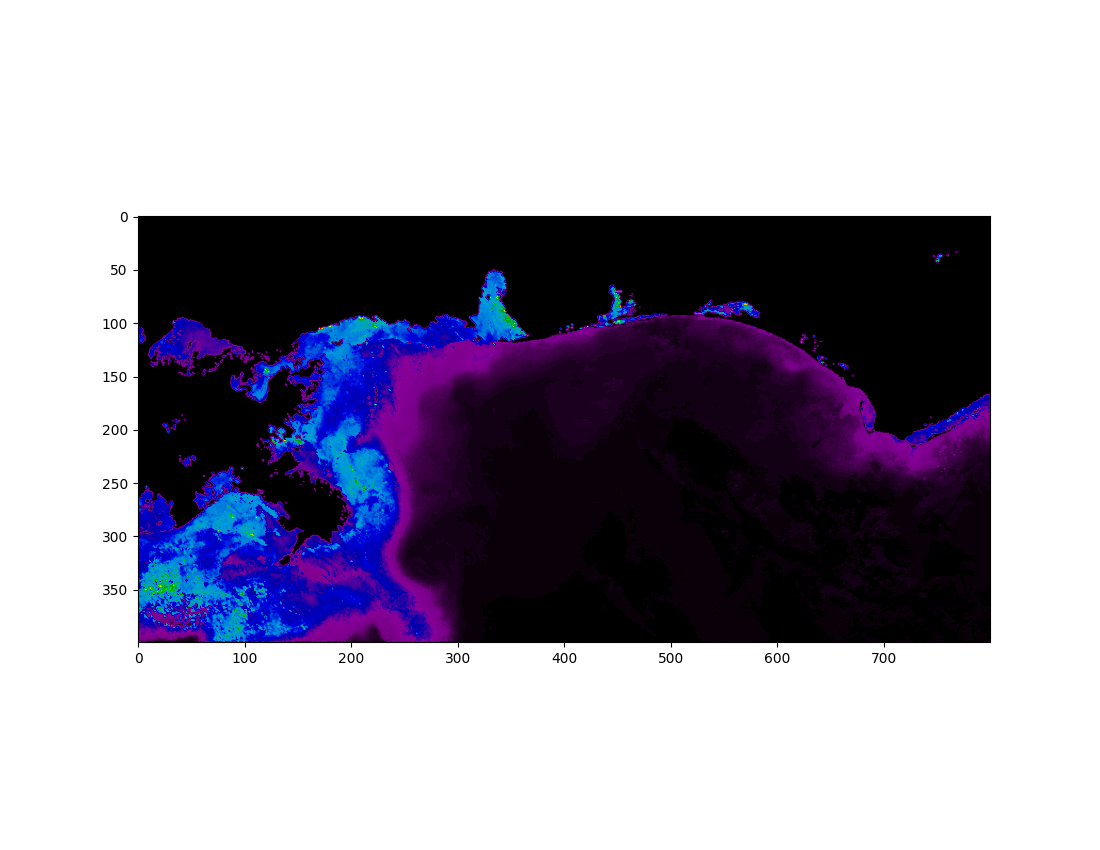 "Plot of Chlorophyll-A for the Gulf of Mexico's MS Bight region after merging data files, saving results to /content/folderOnColab/007_netcdf_merged.jpg.")

Plot of Chlorophyll-A for the Gulf of Mexico's MS Bight region after merging data files, saving results to 
/content/folderOnColab/007_netcdf_merged.jpg.

In [ ]:
# Display Section 508 compliant image on the scrren with ALT text
try:
  make_accessible(plt, jinja2.Template(caption_text), len=len)
  rprint("\n")
  rprint(caption_text)
except (NameError, Exception) as e:
  process_exception(e)

In [ ]:
#CLOSE ALL FILES
rprint("Closing out NetCDF files.")
try:
    rprint("Close Output NetCDF")
    output_netcdf.close()
except Exception as e:
    process_exception(e)

try:
    rprint("Close APS NetCDF")
    aps_netcdf.close()
except Exception as e:
    process_exception(e)

try:
    rprint("Close BioCast NetCDF")
    biocast_netcdf.close()
except Exception as e:
    process_exception(e)

rprint("Finished " + str(VERSION_NAME) + ".")

Closing out NetCDF files.

Close Output NetCDF

Close APS NetCDF

Close BioCast NetCDF

Finished NETCDF-READER.